In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import optuna
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#### Functions

In [272]:
precision_scorer = make_scorer(precision_score, average="binary", zero_division=0)

In [ ]:
def plot_precision_boxplot(results):
    model_names = []
    precision_scores_list = []

    # Extract model names and their respective precision scores
    for model_name, metrics in results.items():
        model_names.append(model_name)
        precision_scores_list.append(metrics["Precision"])

    # Create the boxplot
    fig, ax = plt.subplots()
    ax.boxplot(precision_scores_list, labels=model_names, vert=True, patch_artist=True)

    ax.set_xlabel("Models")
    ax.set_ylabel("Precision Scores")
    ax.set_title("Model Comparison - Precision (Boxplot)")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [278]:
pd.set_option("display.max_columns", None)

### Importing data

In [3]:
print(os.getcwd())

/Users/matheus/Projects/steam_analysis/steam-analysis/notebooks/modeling


In [4]:
os.chdir("../../")

In [191]:
data = pd.read_csv("data/interim/steam-transformed-data.csv")

#### Testing multiple classifier models

In [192]:
# Our data's beahaviour is not regular through time. For that reason We will be limiting ourselves to 2023.
data = data[data["year"] >= 2023]

In [193]:
# Adding a random noise column in order to better understand feature importances
data["random_noise"] = np.random.randn(len(data))

In [194]:
X = data[
    [
        "Achievements",
        "about_length",
        "n_screens",
        "n_movies",
        "n_tags",
        "n_languages",
        "has_publisher",
        "perceived_quality",
        "has_support_email",
        "has_support_url",
        "has_website",
        "random_noise",
    ]
]
y = data["success_500_threshold"]

In [279]:
# Check for colinearities(pearson)
X.corrwith(y).sort_values(ascending=False)

n_movies             0.231083
perceived_quality    0.200393
Achievements         0.190094
n_tags               0.180467
has_publisher        0.129945
has_website          0.089976
has_support_url      0.072976
n_screens            0.069026
about_length         0.048909
n_languages          0.031968
random_noise        -0.009355
has_support_email   -0.112186
dtype: float64

In [195]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [213]:
# List of classifier algos to be tested
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier(),
}


# Function to evaluate classifiers
def evaluate_classifier(clf, X, y, cv_splits=5):
    # Scoring for precision
    scoring = make_scorer(precision_score, average="binary", zero_division=0)

    # Calculate cross-validated scores for precision. Stratified folds by default.
    precision_scores = cross_val_score(clf, X, y, cv=cv_splits, scoring=scoring)
    mean_precision = np.mean(precision_scores)

    return precision_scores

In [214]:
results = {}
for clf_name, clf in classifiers.items():
    precision = evaluate_classifier(clf, X_train, y_train)
    results[clf_name] = {
        "Precision": precision,
    }

[LightGBM] [Info] Number of positive: 184, number of negative: 8848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 9032, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020372 -> initscore=-3.873011
[LightGBM] [Info] Start training from score -3.873011
[LightGBM] [Info] Number of positive: 183, number of negative: 8849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 9032, number of used features: 12
[LightGBM] [Info] [binary:Bo

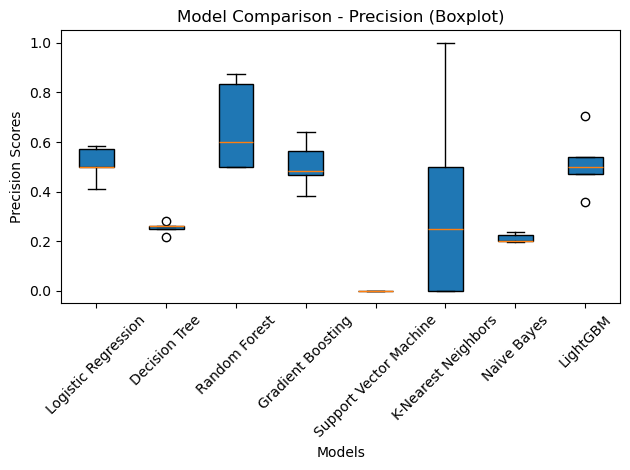

In [215]:
plot_precision_boxplot(results)

The analysis above show us that random forests may be a promising algorithm to model our data. We will train a new random forest model and optimize it with hyperparameter tuning.

In [242]:
# Base model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print(precision_score(y_test, rf.predict(X_test)))

0.7272727272727273


Next, we will tune our hyperparameters using optuna.

In [258]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample", None]
        ),
    }

    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(
        model, X_train, y_train, n_jobs=4, cv=5, scoring=precision_scorer
    )
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2024-05-23 10:47:26,009] A new study created in memory with name: no-name-bc2c42f7-e397-4267-be8b-a15144e76267
[I 2024-05-23 10:47:28,598] Trial 0 finished with value: 0.5333333333333333 and parameters: {'n_estimators': 73, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 11, 'class_weight': None}. Best is trial 0 with value: 0.5333333333333333.
[I 2024-05-23 10:47:28,720] Trial 1 finished with value: 0.1964591346949993 and parameters: {'n_estimators': 10, 'max_depth': 30, 'min_samples_split': 20, 'min_samples_leaf': 18, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5333333333333333.
[I 2024-05-23 10:47:29,472] Trial 2 finished with value: 0.2615237046070598 and parameters: {'n_estimators': 82, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 12, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5333333333333333.
[I 2024-05-23 10:47:30,440] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 89, 'max_depth': 9, 'min_samples

In [277]:
rf = RandomForestClassifier(**study.best_params, random_state=42)
rf.fit(X_train, y_train)
score = precision_score(y_test, rf.predict(X_test))
print(score)

1.0


#### Interpreting the model
 
Permutation importance let us understand how each feature contributes to our model's generalization power. 

Shap values will tell us how the selected features are being used for every individual prediction our trained model does.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


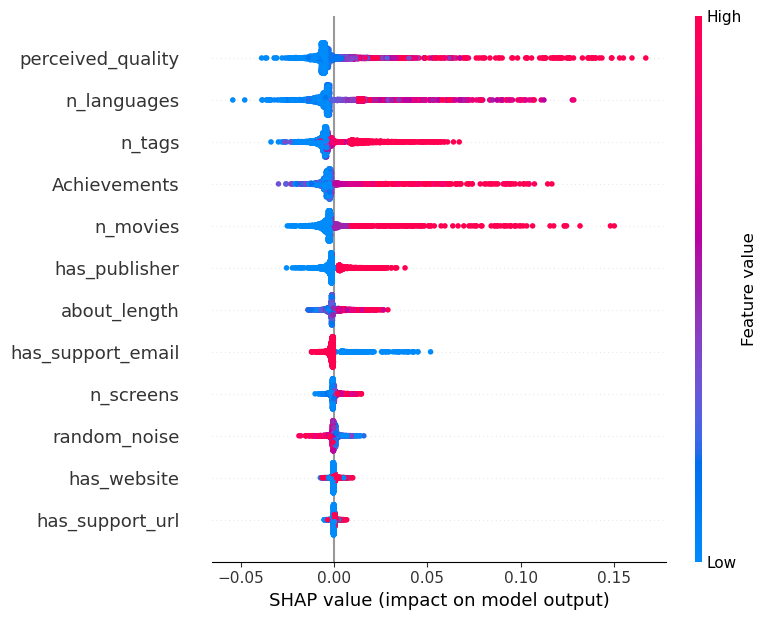

In [264]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary of SHAP values for the test set
shap.summary_plot(shap_values[1], X_test)

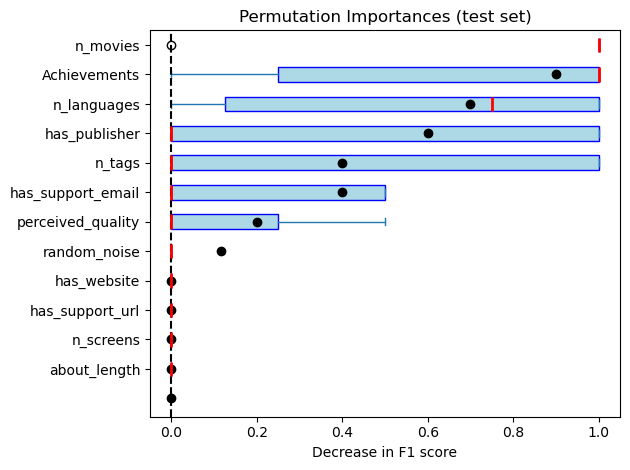

In [274]:
# Plot permutation importances
fig, ax = plt.subplots()
importances.plot.box(
    vert=False,
    whis=10,
    ax=ax,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="black", markeredgecolor="black"),
)

# Adding a mean line
for i in range(importances.shape[1]):
    mean_value = importances.iloc[:, i].mean()
    ax.plot(mean_value, i, "o", color="black")

ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in F1 score")
ax.figure.tight_layout()

plt.show()